In [87]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings

import re
import nltk
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer

warnings.filterwarnings('ignore')
sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (10, 6)

In [4]:
df = pd.read_csv(r"C:\Users\HARD_THAKAR\Downloads\amazon_alexa (1).tsv", delimiter='\t')

In [41]:
print("Feedback - Negative(0), Positive(1)")

df.head()


Feedback - Negative(0), Positive(1)


,rating,date,variation,verified_reviews,feedback,len
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,13
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,9
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1,195
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1,172
4,5,31-Jul-18,Charcoal Fabric,Music,1,5


In [6]:
df.isnull().sum()

rating              0
date                0
variation           0
verified_reviews    1
feedback            0
dtype: int64

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3150 entries, 0 to 3149
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   rating            3150 non-null   int64 
 1   date              3150 non-null   object
 2   variation         3150 non-null   object
 3   verified_reviews  3149 non-null   object
 4   feedback          3150 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 123.2+ KB


variation
Black  Dot                      516
Charcoal Fabric                 430
Configuration: Fire TV Stick    350
Black  Plus                     270
Black  Show                     265
Black                           261
Black  Spot                     241
White  Dot                      184
Heather Gray Fabric             157
White  Spot                     109
White                            91
Sandstone Fabric                 90
White  Show                      85
White  Plus                      78
Oak Finish                       14
Walnut Finish                     9
Name: count, dtype: int64


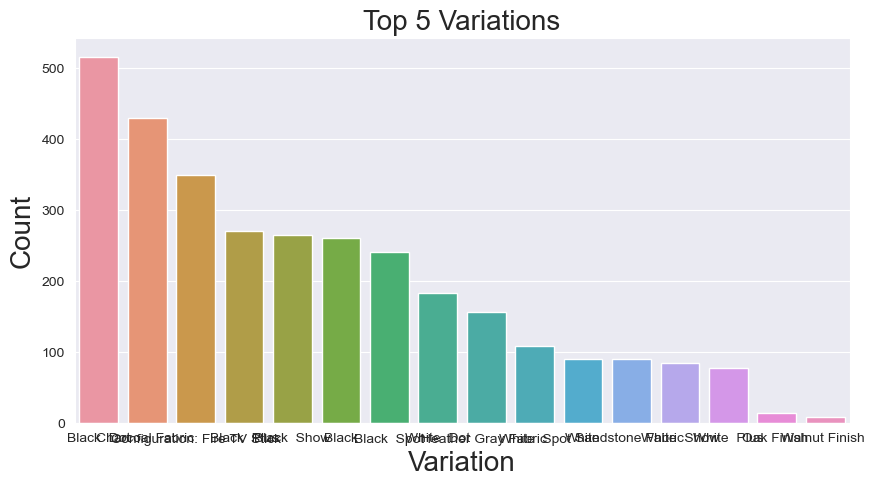

In [27]:
''' value counts of variations '''
variation_label = df.variation.value_counts()#[:5]
print(variation_label)

''' plotting top 5 variations '''
plt.figure(figsize=(10, 5))
sns.barplot(x = variation_label.index, y = variation_label);
plt.xlabel('Variation', fontsize=20)
plt.ylabel('Count', fontsize=20)
plt.title('Top 5 Variations', fontsize=20);

In [12]:
df.shape

(3150, 5)

In [14]:
''' adding a len column for analyzing the length of the reviews '''
df['len'] = df['verified_reviews'].apply(str).str.len()
df['len']

0        13
1         9
2       195
3       172
4         5
       ... 
3145     50
3146    135
3147    441
3148    380
3149      4
Name: len, Length: 3150, dtype: int64

In [20]:
''' displaying data based on len '''
df.groupby('len').describe().sample(10)

rating                                               feedback            \
     count      mean       std  min   25%  50%  75%  max    count      mean   
len                                                                           
437    1.0  4.000000       NaN  4.0  4.00  4.0  4.0  4.0      1.0  1.000000   
405    2.0  3.000000  0.000000  3.0  3.00  3.0  3.0  3.0      2.0  1.000000   
496    2.0  5.000000  0.000000  5.0  5.00  5.0  5.0  5.0      2.0  1.000000   
65    13.0  4.923077  0.277350  4.0  5.00  5.0  5.0  5.0     13.0  1.000000   
26    24.0  4.708333  0.858673  1.0  5.00  5.0  5.0  5.0     24.0  0.958333   
108   10.0  4.400000  1.264911  1.0  4.25  5.0  5.0  5.0     10.0  0.900000   
213    5.0  4.600000  0.547723  4.0  4.00  5.0  5.0  5.0      5.0  1.000000   
446    2.0  3.000000  1.414214  2.0  2.50  3.0  3.5  4.0      2.0  0.500000   
626    1.0  3.000000       NaN  3.0  3.00  3.0  3.0  3.0      1.0  1.000000   
211    6.0  3.833333  1.329160  2.0  3.00  4.0  5.0  5.0      6.0  0.833333   

                                          
          std  min   25%  50%   75%  max  
len                                       
437       NaN  1.0  1.00  1.0  1.00  1.0  
405  0.000000  1.0  1.00  1.0  1.00  1.0  
496  0.000000  1.0  1.00  1.0  1.00  1.0  
65   0.000000  1.0  1.00  1.0  1.00  1.0  
26   0.204124  0.0  1.00  1.0  1.00  1.0  
108  0.316228  0.0  1.00  1.0  1.00  1.0  
213  0.000000  1.0  1.00  1.0  1.00  1.0  
446  0.707107  0.0  0.25  0.5  0.75  1.0  
626       NaN  1.0  1.00  1.0  1.00  1.0  
211  0.408248  0.0  1.00  1.0  1.00  1.0

In [21]:
'''displaying the data according to the Ratings '''
df.groupby('rating').describe()

feedback                                        len              \
          count mean  std  min  25%  50%  75%  max   count        mean   
rating                                                                   
1         161.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   161.0  195.000000   
2          96.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0    96.0  249.177083   
3         152.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0   152.0  207.296053   
4         455.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0   455.0  178.520879   
5        2286.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0  2286.0  108.444007   

                                                       
               std  min    25%    50%     75%     max  
rating                                                 
1       212.371226  1.0  36.00  120.0  284.00  1124.0  
2       269.604896  1.0  78.75  163.0  309.25  1686.0  
3       272.194706  1.0  54.00  130.0  284.00  1954.0  
4       215.927849  1.0  34.00   99.0  241.00  1360.0  
5       152.116387  1.0  26.00   64.0  135.00  2851.0

In [22]:
''' displaying data based according to the feedback '''
df.groupby('feedback').describe()

rating                                                  len  \
           count      mean       std  min  25%  50%  75%  max   count   
feedback                                                                
0          257.0  1.373541  0.484688  1.0  1.0  1.0  2.0  2.0   257.0   
1         2893.0  4.737643  0.546544  3.0  5.0  5.0  5.0  5.0  2893.0   

                                                                   
                mean         std  min   25%    50%    75%     max  
feedback                                                           
0         215.237354  236.329455  1.0  53.0  137.0  289.0  1686.0  
1         124.659177  174.624491  1.0  29.0   69.0  154.0  2851.0

rating
5    2286
4     455
1     161
3     152
2      96
Name: count, dtype: int64


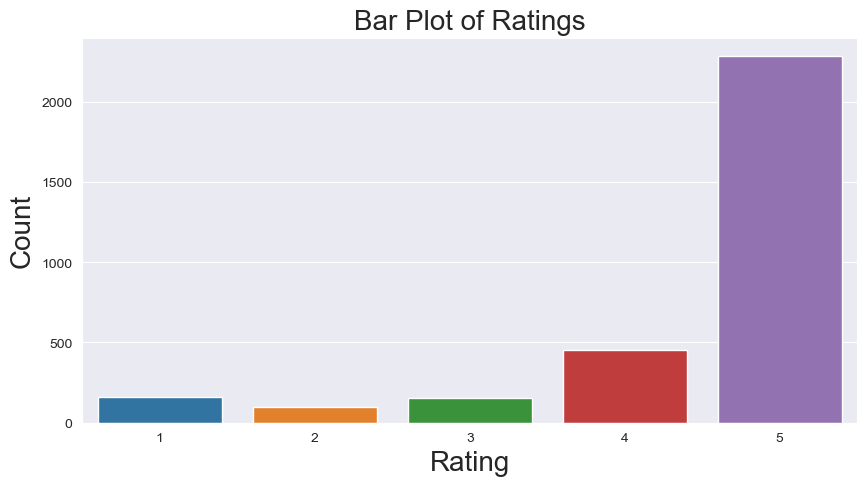

In [24]:
''' value counts of rating '''
rating_label = df.rating.value_counts()
print(rating_label)

''' barplot '''
plt.figure(figsize=(10, 5))
sns.barplot(x = rating_label.index,y = rating_label);
plt.xlabel('Rating', fontsize=20)
plt.ylabel('Count', fontsize=20);
plt.title('Bar Plot of Ratings', fontsize=20);

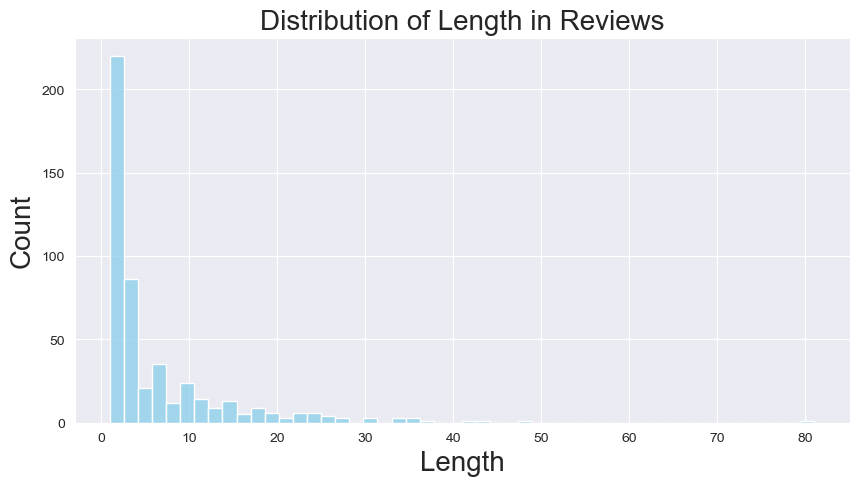

In [28]:
''' histogram plot of len of reivews '''
len_label = df['len'].value_counts()
plt.figure(figsize=(10, 5))
sns.histplot(len_label, bins=50, color='skyblue');
plt.xlabel('Length', fontsize=20)
plt.ylabel('Count', fontsize=20);
plt.title('Distribution of Length in Reviews', fontsize=20);

In [30]:
''' Checking some of the reviews according to thier lengths '''
df[df.len == 1]['verified_reviews'].iloc[0]

'😍'

In [31]:
df[df['len'] == 150]['verified_reviews'].iloc[0]

"Got this on Amazon prime with the ring pro. Work really great. Being the lazy guy I am I don't need to go see who at my door anymore while I'm gaming."

In [32]:
df[df['len'] == 50]['verified_reviews'].iloc[0]

'Yet another Exho for our home and love them all!!!'

In [33]:
df[df['len'] == 25]['verified_reviews'].iloc[0]

'I love it, wife hates it.'

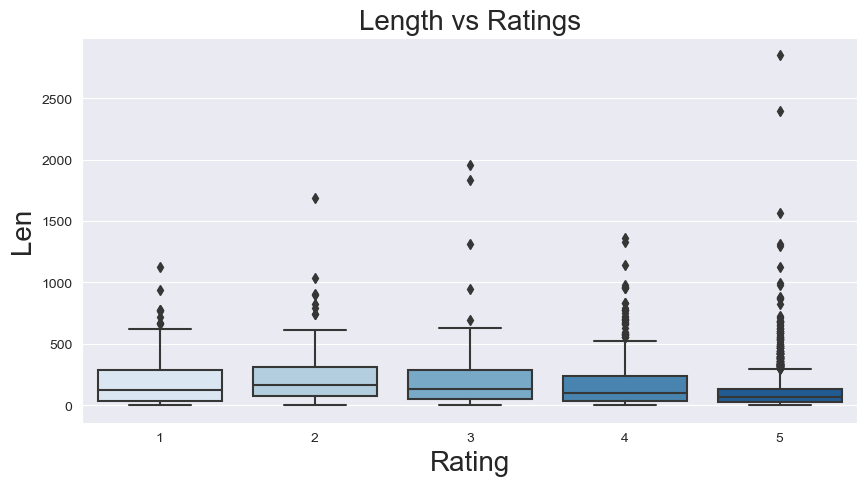

In [38]:
''' Length vs Ratings boxplot '''
plt.figure(figsize=(10, 5))
sns.boxplot(x = df['rating'],y = df['len'], palette = 'Blues')
plt.title("Length vs Ratings", fontsize=20)
plt.xlabel('Rating', fontsize=20)
plt.ylabel('Len', fontsize=20);

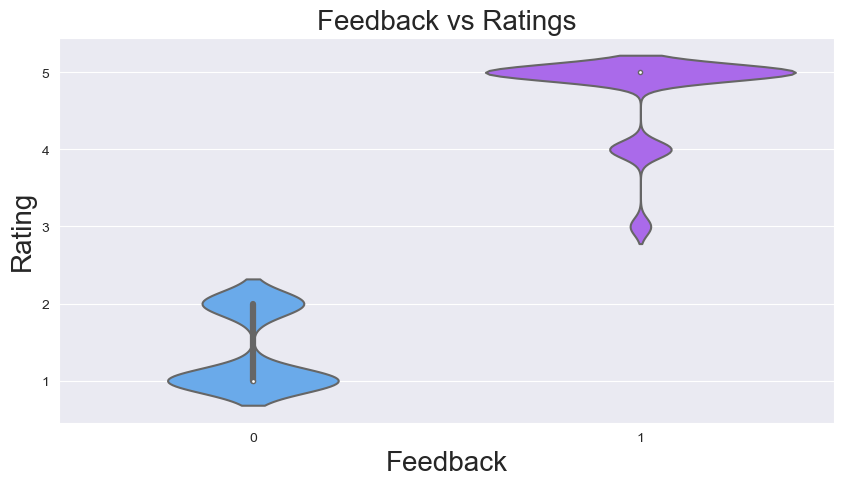

In [39]:
''' Feedback vs Ratings violin plot '''
plt.figure(figsize=(10, 5))
sns.violinplot(x = df['feedback'],y = df['rating'], palette = 'cool')
plt.title("Feedback vs Ratings", fontsize=20)
plt.xlabel('Feedback', fontsize=20)
plt.ylabel('Rating', fontsize=20);

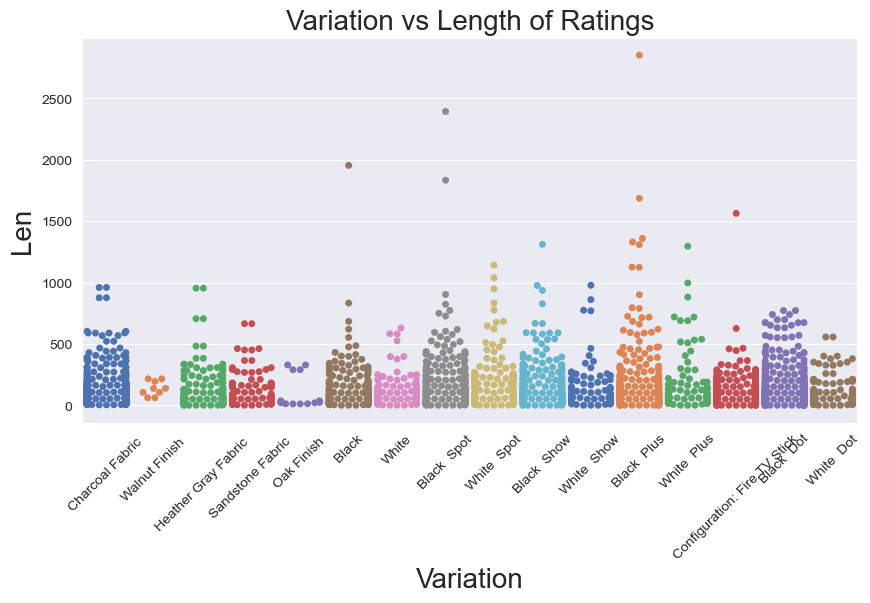

In [43]:
''' Variation vs Length of Ratings swarmplot '''
plt.figure(figsize=(10, 5))
sns.swarmplot(x = df['variation'],y = df['len'], palette = 'deep')
plt.title("Variation vs Length of Ratings", fontsize=20)
plt.xticks(rotation = 45);
plt.xlabel('Variation', fontsize=20)
plt.ylabel('Len', fontsize=20);

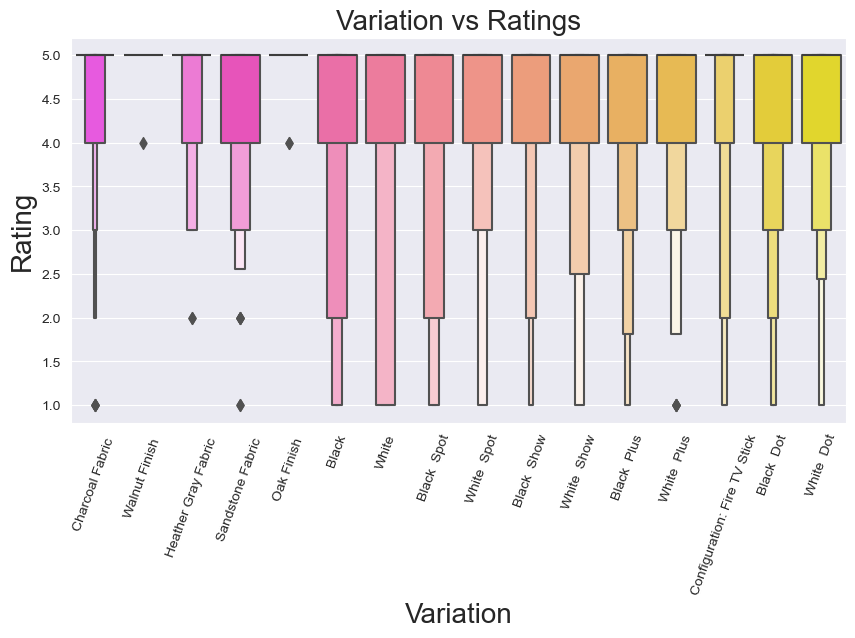

In [48]:
''' bivariate analysis '''
plt.figure(figsize=(10, 5))
sns.boxenplot(x = df['variation'],y = df['rating'], palette = 'spring')
plt.title("Variation vs Ratings", fontsize=20)
plt.xticks(rotation = 70);
plt.xlabel('Variation', fontsize=20)
plt.ylabel('Rating', fontsize=20);

In [51]:
''' Replace NaN values with an empty string or placeholder '''
df['verified_reviews'] = df['verified_reviews'].fillna('')

''' Now apply CountVectorizer '''
count_vector = CountVectorizer(stop_words='english')
ws = count_vector.fit_transform(df['verified_reviews'])

''' Process the word frequencies '''
s_w = ws.sum(axis=0)
w_f = [(w, s_w[0, idx]) for w, idx in count_vector.vocabulary_.items()]
w_f = sorted(w_f, key=lambda x: x[1], reverse=True)

''' Create DataFrame for word frequencies '''
freq = pd.DataFrame(w_f, columns=['word', 'freq'])

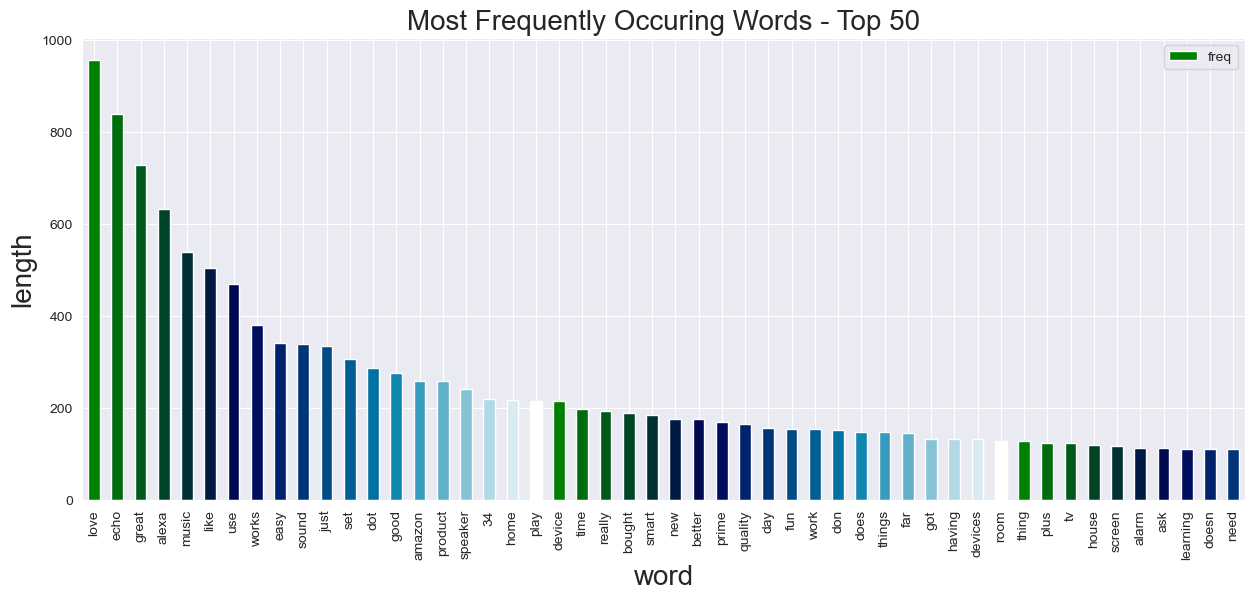

In [52]:
''' barplot of top 50 frequently occuring words '''
color = plt.cm.ocean(np.linspace(0, 1, 20))
freq.head(50).plot(x='word', y='freq', kind='bar', figsize=(15, 6), color = color)
plt.title("Most Frequently Occuring Words - Top 50", fontsize=20)
plt.xlabel('word', fontsize=20)
plt.ylabel('length', fontsize=20);

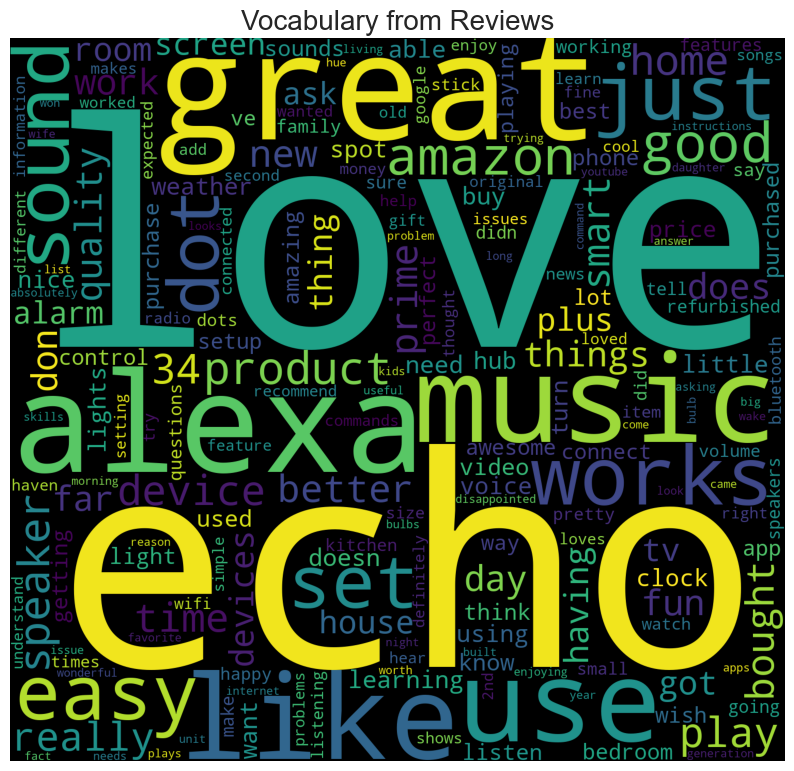

In [53]:
''' representing words on WordCloud '''
word_cloud = WordCloud(background_color='black', width=1500, height=1400).generate_from_frequencies(dict(w_f))
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.imshow(word_cloud)
plt.title("Vocabulary from Reviews", fontsize = 20);

In [55]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HARD_THAKAR\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [56]:
''' Preproecessing '''
c = []

for i in range(0, 3150):
    ''' removing characters except a-z and A-Z'''
    r = re.sub('[^a-zA-Z]', ' ', df['verified_reviews'][i])
    ''' converting every word into lower word'''
    r = r.lower()
    ''' splitting text '''
    r = r.split()
    ''' apllying Stemming '''
    ps = PorterStemmer()
    ''' removing stopwords '''
    sw = stopwords.words('english')
    sw.remove('not')
    r = [ps.stem(word) for word in r if not word in set(sw)]
    r = ' '.join(r)
    c.append(r)

In [57]:
''' count vectorizer '''
count_vector = CountVectorizer(max_features=2500) 

''' independent and dependent variables '''
X = count_vector.fit_transform(c).toarray()
y = df.iloc[:, 4].values

''' checking shape '''
print(X.shape)
print(y.shape)

(3150, 2500)
(3150,)


In [60]:
''' train test split '''
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [61]:
print("shape of X_train: ", X_train.shape)
print("shape of X_test: ", X_test.shape)

shape of X_train:  (2362, 2500)
shape of X_test:  (788, 2500)


In [62]:
''' Min Max Scaler '''
min_max_sc = MinMaxScaler()

X_train = min_max_sc.fit_transform(X_train)
X_test = min_max_sc.transform(X_test)

              precision    recall  f1-score   support

           0       0.81      0.40      0.53        73
           1       0.94      0.99      0.97       715

    accuracy                           0.94       788
   macro avg       0.87      0.69      0.75       788
weighted avg       0.93      0.94      0.93       788



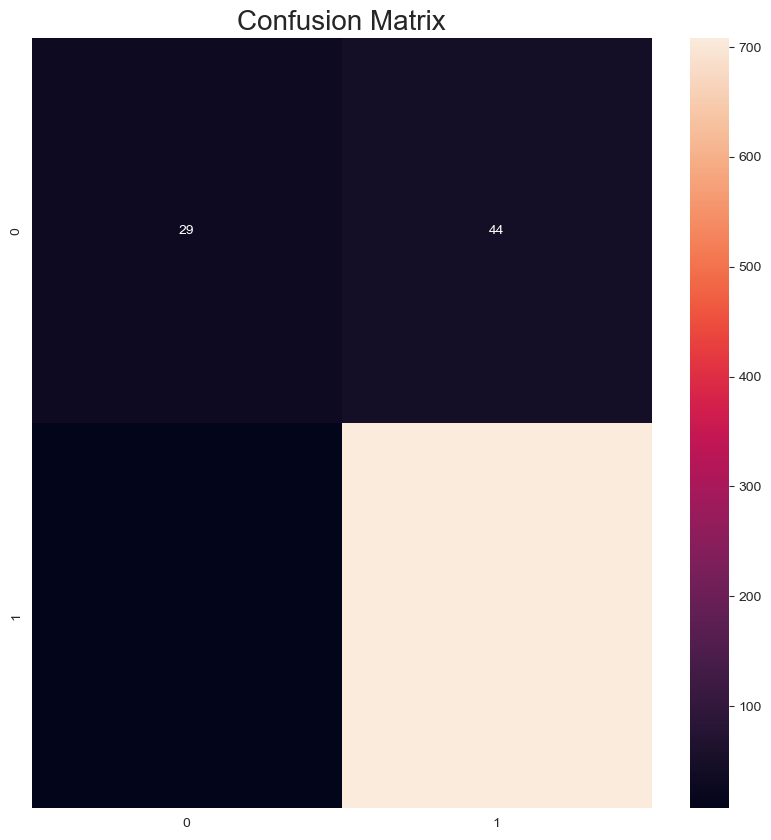

In [90]:
''' Random Forest Classifier '''
rf = RandomForestClassifier()

''' fit on data '''
rf.fit(X_train, y_train)

''' prediction '''
y_pred = rf.predict(X_test)

''' confusion matrix '''
print(classification_report(y_test, y_pred))
plt.figure(figsize=(10, 10))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='g');
plt.title('Confusion Matrix', fontsize=20);